# Simple usage

This notebook demonstrates basic usage of the *openTSNE* library. This is sufficient for almost all use-cases.

In [1]:
from openTSNE import TSNE

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In most of the notebooks, we will be using the Macosko 2015 mouse retina data set. This is a fairly well-known and well explored data set in the single-cell literature making it suitable as an example. The preprocessed data set can be downloaded from http://file.biolab.si/opentsne/benchmark/macosko_2015.pkl.gz.

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Run t-SNE

We'll first create an embedding on the training data.

In [6]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [7]:
%time embedding_train = tsne.fit(x_train)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 8.82 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.70 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.21 seconds
===> Running optimization with exaggeration=12.00, lr=2501.75 for 250 iterations...
Iteration   50, KL divergence 5.1633, 50 iterations in 2.5187 sec
Iteration  100, KL divergence 5.0975, 50 iterations in 2.5269 sec
Iteration  150, KL divergence 5.0648, 50 iterations in 2.5661 sec
Iteration  200, KL divergence 5.0510, 50 iterations in 2.3758 sec
Iteration  250, KL divergence 5.0430, 50 iterations in 2.4623 sec
   --> Time elapsed: 12.45 seconds
===> Running optimization with exaggeration=

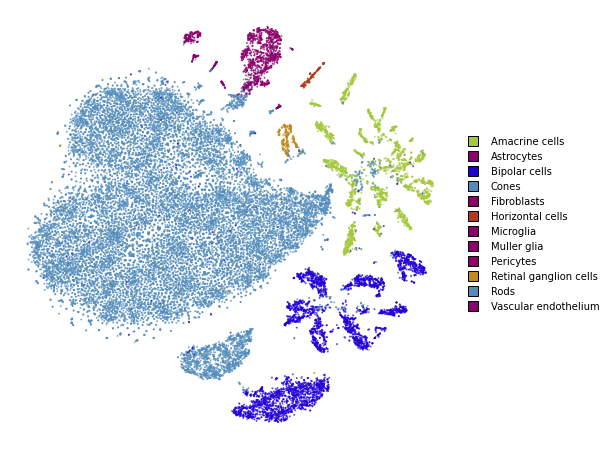

In [8]:
utils.plot(embedding_train, y_train, colors=utils.MACOSKO_COLORS)

## Transform

openTSNE is currently the only library that allows embedding new points into an existing embedding.

In [9]:
%time embedding_test = embedding_train.transform(x_test)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 3.54 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.04 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 213718.9013, 50 iterations in 0.4314 sec
Iteration  100, KL divergence 212177.4468, 50 iterations in 0.4447 sec
Iteration  150, KL divergence 211186.1793, 50 iterations in 0.4477 sec
Iteration  200, KL divergence 210471.7728, 50 iterations in 0.4193 sec
Iteration  250, KL divergence 209921.5693, 50 iterations in 0.4285 sec
   --> Time elapsed: 2.17 seconds
CPU times: user 10.4 s, sys: 864 ms, total: 11.2 s
Wall time: 6.72 s


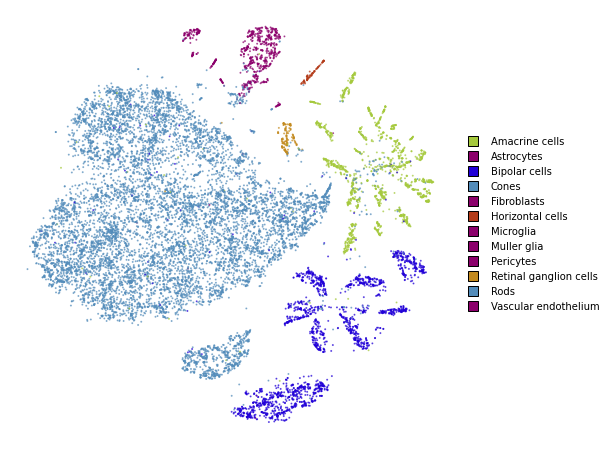

In [10]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

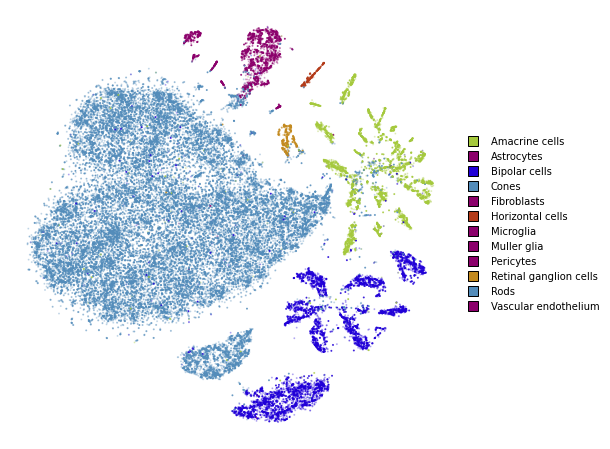

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_train, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)